<a href="https://colab.research.google.com/github/jo49973477/naverblog/blob/main/ResNet_Running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration

In [ ]:
config = {
    'batch_size': 16,
    'learning rate': 0.0001,
    'epoch': 8,
    'DEVICE': "cuda" if torch.cuda.is_available() else "cpu",
    'lambda': 0.0005,
}

print(config['DEVICE'])

cuda


# 2. Loading the Dataset
## Loading the Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=config['batch_size'],
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Image Example Showing

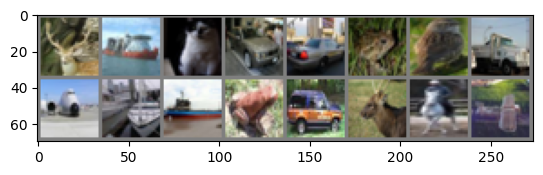

deer  ship  cat   car   car   frog  bird  truck plane ship  ship  frog  car   deer  horse plane
Image Size: torch.Size([3, 32, 32])


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(config['batch_size'])))

C, H, W = images[0].shape
print("Image Size: {}".format(images[0].shape))

# 2. Model:: ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1, self.layer2, self.layer3, self.layer4 = None, None, None, None
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(int(512 * block.expansion), num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Create ResNet models
def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet50(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes=num_classes)

# 3. Running Model

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
model = resnet18()
summary(model, input_size=(config['batch_size'], C, H, W))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 16, 16]          128
├─ReLU: 1-3                              [16, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [16, 64, 8, 8]            --
├─Sequential: 1-5                        [16, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 8, 8]            128
│    │    └─Sequential: 3-6              [16, 64, 8, 8]            --
│

In [ ]:
summary(resnet50(), input_size=(config['batch_size'], C, H, W))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 16, 16]          128
├─ReLU: 1-3                              [16, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [16, 64, 8, 8]            --
├─Sequential: 1-5                        [16, 256, 8, 8]           --
│    └─BottleneckBlock: 2-1              [16, 256, 8, 8]           --
│    │    └─Conv2d: 3-1                  [16, 64, 8, 8]            4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [16, 64, 8, 8]            --
│ 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning rate'], weight_decay = config['lambda'])
criterion = nn.CrossEntropyLoss().to(config['DEVICE'])

print("Device:  ", config['DEVICE'])

Device:   cuda


In [ ]:
train_loss_18 = []
train_acc_18 = []
test_loss_18 = []
test_acc_18 = []
tracker_18 = []

for epoch in range(1, config['epoch']+1):

    train_losses   = []
    train_accuracy = []
    model.train()

    for i, batch in enumerate(trainloader):
        #Extract data, labels
        img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
        model.to(config['DEVICE'])
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        #Train model
        optimizer.zero_grad()
        output = model(img_batch).to(config['DEVICE']) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)
        train_losses.append(loss.item())
        train_accuracy.append(acc.cpu())

        # Update global metrics
        total_loss = np.mean(train_losses)
        total_acc = np.mean(train_accuracy)
        train_loss_18.append(total_loss)
        train_acc_18.append(total_acc)


        #Just checking...
        if i % 500 == 0:
            print(f'Train Epoch: {epoch}, batch: {i}/{len(trainloader)} | Batch metrics | loss: {total_loss:.4f}, accuracy: {total_acc:.3f}')

        #Update learning rate
        tracker_18.append(optimizer.state_dict()['param_groups'][0]['lr'])

    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(testloader):
        img_batch, label_batch = batch
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        output = model(img_batch) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)

        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)

        total_loss += loss.item()
        total_acc += acc.cpu()

    total_loss /= len(testloader)
    total_acc /= len(testloader)

    test_loss_18.append(total_loss)
    test_acc_18.append(total_acc)

    print(f"----EPOCH{epoch} TEST----")
    print(f"LOSS: {total_loss:.4f} | ACCURACY : {total_acc:.3f}")

Train Epoch: 1, batch: 0/3125 | Batch metrics | loss: 2.2887, accuracy: 0.062
Train Epoch: 1, batch: 500/3125 | Batch metrics | loss: 1.8477, accuracy: 0.340
Train Epoch: 1, batch: 1000/3125 | Batch metrics | loss: 1.7029, accuracy: 0.390
Train Epoch: 1, batch: 1500/3125 | Batch metrics | loss: 1.6270, accuracy: 0.417
Train Epoch: 1, batch: 2000/3125 | Batch metrics | loss: 1.5642, accuracy: 0.440
Train Epoch: 1, batch: 2500/3125 | Batch metrics | loss: 1.5169, accuracy: 0.457
Train Epoch: 1, batch: 3000/3125 | Batch metrics | loss: 1.4759, accuracy: 0.474
----EPOCH1 TEST----
LOSS: 1.2086 | ACCURACY : 0.572
Train Epoch: 2, batch: 0/3125 | Batch metrics | loss: 1.0358, accuracy: 0.625
Train Epoch: 2, batch: 500/3125 | Batch metrics | loss: 1.1361, accuracy: 0.598
Train Epoch: 2, batch: 1000/3125 | Batch metrics | loss: 1.1312, accuracy: 0.601
Train Epoch: 2, batch: 1500/3125 | Batch metrics | loss: 1.1265, accuracy: 0.604
Train Epoch: 2, batch: 2000/3125 | Batch metrics | loss: 1.1146, 

In [ ]:
model = resnet50()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning rate'], weight_decay = config['lambda'])
criterion = nn.CrossEntropyLoss().to(config['DEVICE'])

print("Device:  ", config['DEVICE'])

Device:   cuda


In [ ]:

train_loss_50 = []
train_acc_50 = []
test_loss_50 = []
test_acc_50 = []
tracker_50 = []


for epoch in range(1, config['epoch']+1):

    train_losses   = []
    train_accuracy = []
    model.train()

    for i, batch in enumerate(trainloader):
        #Extract data, labels
        img_batch, label_batch = batch   #img [B,3,H,W], label[B,N_CLASSES]
        model.to(config['DEVICE'])
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        #Train model
        optimizer.zero_grad()
        output = model(img_batch).to(config['DEVICE']) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)
        loss.backward()
        optimizer.step()

        #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)
        train_losses.append(loss.item())
        train_accuracy.append(acc.cpu())

        # Update global metrics
        total_loss = np.mean(train_losses)
        total_acc = np.mean(train_accuracy)
        train_loss_50.append(total_loss)
        train_acc_50.append(total_acc)


        #Just checking...
        if i % 500 == 0:
            print(f'Train Epoch: {epoch}, batch: {i}/{len(trainloader)} | Batch metrics | loss: {total_loss:.4f}, accuracy: {total_acc:.3f}')

        #Update learning rate
        tracker_50.append(optimizer.state_dict()['param_groups'][0]['lr'])

    total_loss = 0
    total_acc = 0

    for i, batch in enumerate(testloader):
        img_batch, label_batch = batch
        img_batch = img_batch.to(config['DEVICE'])
        label_batch = label_batch.type(torch.LongTensor).to(config['DEVICE'])

        output = model(img_batch) # output: [B, 7, H, W]
        loss   = criterion(output, label_batch)

        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == label_batch) / len(preds)

        total_loss += loss.item()
        total_acc += acc.cpu()

    total_loss /= len(testloader)
    total_acc /= len(testloader)

    test_loss_50.append(total_loss)
    test_acc_50.append(total_acc)

    print(f"----EPOCH{epoch} TEST----")
    print(f"LOSS: {total_loss:.4f} | ACCURACY : {total_acc:.3f}")

Train Epoch: 1, batch: 0/3125 | Batch metrics | loss: 2.7349, accuracy: 0.000
Train Epoch: 1, batch: 500/3125 | Batch metrics | loss: 2.2782, accuracy: 0.197
Train Epoch: 1, batch: 1000/3125 | Batch metrics | loss: 2.1337, accuracy: 0.241
Train Epoch: 1, batch: 1500/3125 | Batch metrics | loss: 2.0301, accuracy: 0.273
Train Epoch: 1, batch: 2000/3125 | Batch metrics | loss: 1.9605, accuracy: 0.298
Train Epoch: 1, batch: 2500/3125 | Batch metrics | loss: 1.9004, accuracy: 0.318
Train Epoch: 1, batch: 3000/3125 | Batch metrics | loss: 1.8542, accuracy: 0.335
----EPOCH1 TEST----
LOSS: 1.5684 | ACCURACY : 0.424
Train Epoch: 2, batch: 0/3125 | Batch metrics | loss: 1.2696, accuracy: 0.500
Train Epoch: 2, batch: 500/3125 | Batch metrics | loss: 1.5276, accuracy: 0.448
Train Epoch: 2, batch: 1000/3125 | Batch metrics | loss: 1.5064, accuracy: 0.454
Train Epoch: 2, batch: 1500/3125 | Batch metrics | loss: 1.4973, accuracy: 0.462
Train Epoch: 2, batch: 2000/3125 | Batch metrics | loss: 1.4886, 

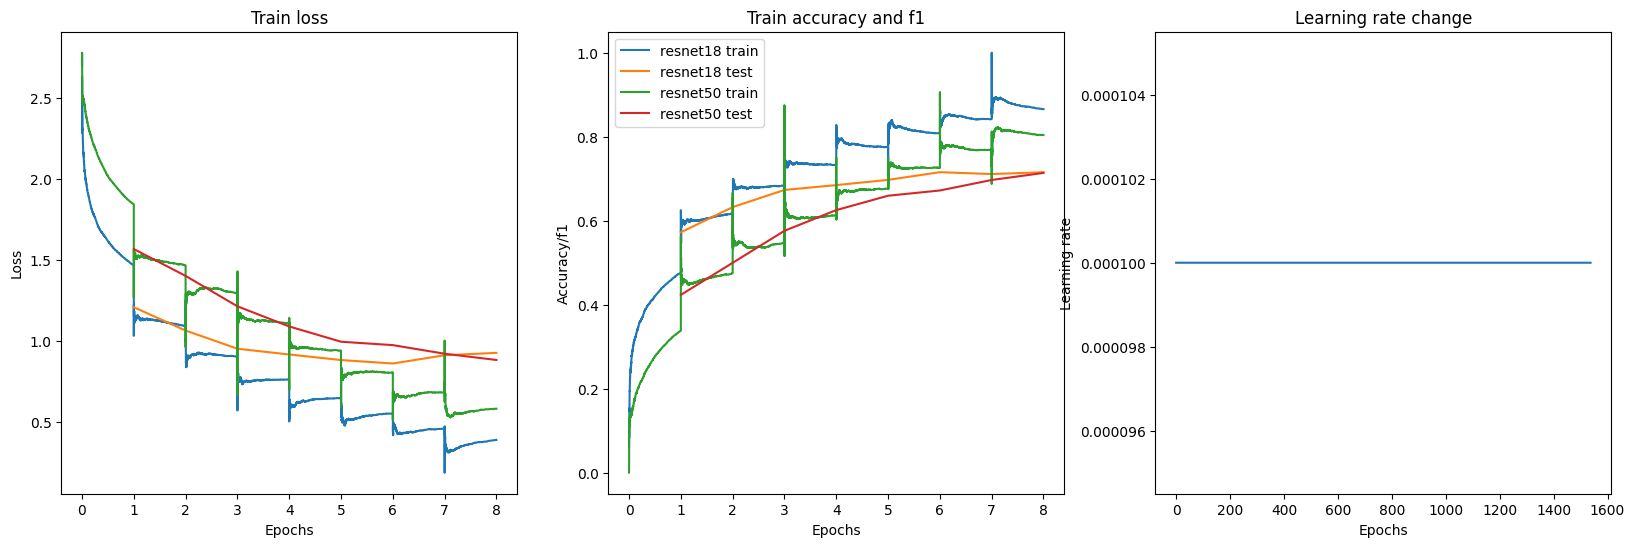

In [ ]:
train_x = np.linspace(0, config['epoch'], len(trainloader) * config['epoch'])
test_x = np.arange(1, config['epoch']+1)

f, axarr = plt.subplots(1,3, figsize = (20,6))
axarr[0].plot(train_x, train_loss_18, label='resnet18 train')
axarr[0].plot(test_x, test_loss_18, label='resnet18 test')
axarr[0].plot(train_x, train_loss_50, label='resnet50 train')
axarr[0].plot(test_x, test_loss_50, label='resnet50 test')
axarr[0].set_title('Train loss')
axarr[0].set_xlabel('Epochs')
axarr[0].set_ylabel('Loss')

axarr[1].plot(train_x, train_acc_18, label='resnet18 train')
axarr[1].plot(test_x, test_acc_18, label='resnet18 test')
axarr[1].plot(train_x, train_acc_50, label='resnet50 train')
axarr[1].plot(test_x, test_acc_50, label='resnet50 test')
axarr[1].set_title('Train accuracy and f1')
axarr[1].set_xlabel('Epochs')
axarr[1].set_ylabel('Accuracy/f1')
axarr[1].legend()

axarr[2].plot(np.arange(len(tracker_18)), tracker_18)
axarr[2].set_title('Learning rate change')
axarr[2].set_xlabel('Epochs')
axarr[2].set_ylabel('Learning rate')

plt.show()